Lo primero es el webscrapping

Cargas el siguiente cuadro y en el navegador que se abre vas a la página que deseas leer y luego presionas "Guardar html", le pones el nombre que corresponda según el cuadro de código que lo leerá y ya está, tienes que asegurarte de hacer eso con todas las cuentas

Extrae el html de esta página (primero asegurate de tener activos los filtros que quieres) (click derecho y click en "guardar página como" o en "guardar como html")... No automatizar esto es lo más seguro (y no es ilegal), además de que es quizas más eficiente a largo plazo.

In [16]:
import webbrowser

webbrowser.open("https://www.paypal.com/myaccount/activities/?free_text_search=&start_date=2023-01-01&end_date=2023-03-15&type=&status=&currency=&filter_id=&issuance_product_name=&asset_names=&asset_symbols=")

True

Empezamos las lecturas de los html, cada cuadro lee una cuenta diferente y empezamos por paypal. Al leer los html con bs4 luego se guarda la información seleccionada, organizada y clasificada en un .csv

Algunas cuentas como las del banreservas es mejor solo exportar el csv que te ofrece la página (paypal también ofrece pero me pareció insuficiente así que mejor extraje de un html).

In [120]:
# Importaciones
from bs4 import BeautifulSoup
import pandas as pd


In [123]:
#Leamos, procesemos y despleguemos la informacion de paypal

with open("paypal_trans.html", encoding="utf-8") as ppt:
    ppt_data = ppt.read()
    soup = BeautifulSoup(ppt_data, "html.parser")
    # print(soup.prettify())
    
   #this contains all transactions data of the page
    container = soup.find("div", attrs={"data-testid":"activity-tile"}) #container = soup.find(id="app") takes too much childs
    # print(container.prettify())
     
    #names of the other persons in the transactions. I take the id from the class name of the container of all the transactions, just taking this will be easier than looping from this general container but i will still be able to identify the transaction just in case. Yes, this is the real paypal transation id
    #taking the name and the id together isntead of individual will make this more secure since we can now for sure that the id corresponds to this specific transaction
    counterparties = {}
    cnames = [] #the pandas dataframes does not accepts
    for name in container.findAll('div',
                                 attrs={"data-cy":'counterpartyName'}):
        transaction_id = name.parent.parent.parent.parent["class"][1][19:]
        counterparties[name.text] = transaction_id
        cnames.append(name.text)
    print(counterparties)
    print(cnames)
    
    #dates and info are together, i'll extract and separe them. This way is easier
    dates_no_format = []
    info = [] #type of transaction
    for date in container.findAll('div',
                                  attrs={"transaction-date-type-status-container"}):
        date_info = date.text
        dot = str.find(date_info,"·")
        dates_no_format.append(date_info[:dot])
        info.append(date_info[dot+1:])
    print(info)

    #translate obtaied dates (example "8 mar") to a full and esthetic date
    dates = []
    for date in dates_no_format:
        day, month = date.split()

        # Dictionary with month name abbreviation and corresponding number
        month_dict = {
            'ene': '01',
            'feb': '02',
            'mar': '03',
            'abr': '04',
            'may': '05',
            'jun': '06',
            'jul': '07',
            'ago': '08',
            'sep': '09',
            'oct': '10',
            'nov': '11',
            'dic': '12'
        }

        # Add leading zero to day if necessary
        day = day.zfill(2)

        # Convert month name abbreviation to number
        month_num = month_dict[month.lower()]

        # Format date as DD/MM
        formatted_date = f"{day}/{month_num}"
        dates.append(formatted_date)
        
    print(dates)

    
    #amount of the transactions
    amounts = []
    change = [] #is the amount plus the symbol of subtraction or adittion as corresponds
    for amount in container.findAll('div',
                                 attrs={"data-cy":'transactionAmount'}):
        amounts_change = amount.text
        if info[len(change)] == "Transferir a cuenta bancaria":
            change.append(amounts_change.replace("+", "*-").replace("-", "*-")) #*- significa "transferencia de salida", que no es lo mismo que gasto o perdida. Esto es un retiro a la cuenta bancaria
        else:
            change.append(amounts_change)
        if amounts_change[len(amounts_change)-1].isdigit() == True: #this is to delete the name of the currency from the end of the number (just in non USD trnasactions)
            amounts.append(amounts_change[2:])
        else:
            amounts.append(amounts_change[2:len(amounts_change)-4])
    print(amounts)
    print(change)
    
    #messages left with the transaction
    messages = {}
    for message in container.findAll('div',
                                 attrs={"data-cy":'notes'}):
        # transaction_id = message.parent.parent.parent.parent["class"][1][19:]
        date_of_message = message.parent.parent.parent.parent.find(
            'div', attrs={"transaction-date-type-status-container"}) #I take the date because is a lot easier to find the index using this (not every transaction have a message)
        messages[date_of_message.text[:str.find(date_of_message.text, ".")+1]] = message.text
    print(messages)
        
    #every transaction have a link to acces to a very more detailed info about them, here is get this link. In the link i can find things like paypal comision, counterparty contact info, counterparty direction and transaction id
    details_links = []
    for counterpart in container.findAll('div',
                                 attrs={"data-cy":'counterpartyName'}): #i take part of the classes name to find them
        details = counterpart.parent.parent.parent.parent
        details_links.append("https://www.paypal.com"+details["data-href"])
    print(details_links)
    
    #Use pandas to create the .csv
    messages2 = [] #lets make the messages dictionary bigger,a list and with the correct index to make it adecuate for the data frame
    for date in dates:
        if date not in messages:
            messages2.append("")
        else:
            messages2.append(messages[date])
    info = {"Nombre": cnames, "Fecha": dates, "Tipo":info, "Cantidad":amounts, "Efecto":change, "Mensaje": messages2,"Detalles":details_links}
    df = pd.DataFrame(data = info)
    print(df)
    df.to_csv('paypal_data.csv')#, index=False, sep="\t")


{'Banco de Reservas de la Republica Dominicana': '28B551335H768814N', 'Uber BV': '12W54441RT095925X', 'FIVERR INTERNATIONAL LTD.': '1HE32494NN681310J'}
['Banco de Reservas de la Republica Dominicana', 'Uber BV', 'Uber BV', 'Uber BV', 'Banco de Reservas de la Republica Dominicana', 'Uber BV', 'Uber BV', 'Uber BV', 'Banco de Reservas de la Republica Dominicana', 'FIVERR INTERNATIONAL LTD.']
['Transferir a cuenta bancaria', 'Pago automático', 'Pago automático', 'Pago automático', 'Transferir a cuenta bancaria', 'Pago automático', 'Pago automático', 'Pago automático', 'Transferir a cuenta bancaria', 'Pago recibido']
['08/03', '07/03', '07/03', '07/03', '06/03', '27/02', '24/02', '21/02', '10/02', '10/02']
['$10,492.0', '$60.0', '$84.2', '$114.6', '$7,863.0', '$219.0', '$145.0', '$100.0', '$2,613.0', '$178.80']
['*- $10,492.00DOP', '- $60.00DOP', '- $84.27DOP', '- $114.69DOP', '*- $7,863.00DOP', '- $219.00DOP', '- $145.00DOP', '- $100.00DOP', '*- $2,613.00DOP', '+ $178.80']
{}
['https://www

In [12]:
#leer csv, pandas
df = pd.read_csv("paypal_data.csv")
# print(df.head())
print(df.columns.tolist())


['Unnamed: 0', 'Nombre', 'Fecha', 'Tipo', 'Cantidad', 'Efecto', 'Mensaje', 'Detalles']


Transformar el csv de banreservas al formato de Paypal (entra en la página de banreservas e imprime el csv del periodo que quieras)

In [6]:
import pandas as pd

df = pd.read_csv("banreservas_informe_oficial.csv", encoding="latin-1")
print(df.columns.tolist())



['Producto', 'Fecha', 'Concepto', 'Id de transacción', 'Débito', 'Crédito', 'Balance', 'Descripción', 'Referencia', 'Unnamed: 9']


In [129]:
import pandas as pd

# Leer los datos del archivo CSV
df_pre = pd.read_csv('banreservas_informe_oficial.csv', encoding='latin-1')

#Efecto y Cantidad
Efecto = []
Cantidad = []
for index, i in enumerate(df_pre["Balance"]):
    if df_pre["Débito"][index] > df_pre["Crédito"][index]:
        Efecto.append("- {0}DOP".format(df_pre["Débito"][index],))
        Cantidad.append("{0}".format(df_pre["Débito"][index],))
    if df_pre["Crédito"][index] > df_pre["Débito"][index]:
        Cantidad.append("{0}".format(df_pre["Crédito"][index],))

        if df_pre["Concepto"][index][0] == "X": #Esto porque los depositos desde paypal suelen tener descripciones automáticas que comienzan con "X", si esto cambia entonces cambia esta línea
            Efecto.append("*+ {0}DOP".format(df_pre["Crédito"][index],)) #*+ significa "transferencia de entrada", que no es lo mismo que ingreso o ganancia. Esto es un deposito desde otra cuenta
        else:
            Efecto.append("+ {0}DOP".format(df_pre["Crédito"][index],))

print(Efecto)


# Escribir los datos del nuevo archivo
info = {"Nombre": df_pre["Concepto"], "Fecha": df_pre["Fecha"], "Tipo":df_pre["Descripción"], "Cantidad":Cantidad, "Efecto":Efecto, "Mensaje": df_pre["Descripción"],"Detalles":df_pre["Descripción"]}
df_post = pd.DataFrame(data = info)
print(df_post)
df_post.to_csv('banreservas_informe_modificado.csv')#, index=False, sep="\t")


['- 0.23DOP', '- 150.00DOP', '- 0.15DOP', '- 100.00DOP', '*+ 10,492.00DOP', '- 69.00DOP', '- 46,000.00DOP', '*+ 7,863.00DOP', '- 50.00DOP', '- 2,238.65DOP', '- 0.15DOP', '- 100.00DOP', '- 0.09DOP', '- 60.00DOP', '*+ 2,613.00DOP', '- 337.00DOP', '- 1,369.00DOP', '- 50.00DOP', '- 50.00DOP', '- 50.00DOP']
                                       Nombre       Fecha  \
0              COBRO IMP DGII 0.15%_TRANS TUB  10/03/2023   
1                    RECARGA CLARO TUBANCOAPP  10/03/2023   
2              COBRO IMP DGII 0.15%_TRANS TUB  09/03/2023   
3                    RECARGA CLARO TUBANCOAPP  09/03/2023   
4                                    XP3247TX  08/03/2023   
5              COBRO IMP DGII 0.15%_TRANS TUB  07/03/2023   
6   TRANSFERENCIA A BIOSCOMPUTER FERNANDEZ RE  07/03/2023   
7                                    XQMGMF3T  06/03/2023   
8         CARGO MENSUAL USO TARJETA DE DEBITO  06/03/2023   
9                 210223 PLAZA LAMA 27 DE FEB  23/02/2023   
10             COBRO IMP 

In [ ]:
#leer csv, pandas
df = pd.read_csv("banreservas_informe_modificado.csv")
# print(df.head())
print(df.columns.tolist())

Crear documento combinado de paypal y Banreservas

In [131]:
import pandas as pd

# Leer los datos del primer archivo CSV
df1 = pd.read_csv('paypal_data.csv')

# Leer los datos del segundo archivo CSV
df2 = pd.read_csv('banreservas_informe_modificado.csv')

# Concatenar los dos DataFrames
df = pd.concat([df1, df2])

# Escribir el nuevo archivo CSV
df.to_csv('todas_mis_transacciones.csv')

Debajo están las evaluaciones de la cuenta que elijas en la celda que lee el archivo (dos celdas abajo de esta)

In [78]:
#imports
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
import numpy as np

In [79]:
#leer csv, pandas
df = pd.read_csv("todas_mis_transacciones.csv")
# print(df.head())
print(df.columns.tolist())

['Unnamed: 0.1', 'Unnamed: 0', 'Nombre', 'Fecha', 'Tipo', 'Cantidad', 'Efecto', 'Mensaje', 'Detalles']


In [80]:
def usd_to_dop(usd_amount):
    import requests

    url = "https://api.apilayer.com/exchangerates_data/convert?to=DOP&from=USD&amount={0}".format(usd_amount)

    payload = {}
    headers= {
    "apikey": "0sUHpvMtNUkjkp3FUU2ZenV3ZjUl8p0I"
    }

    response = requests.request("GET", url, headers=headers, data = payload)

    status_code = response.status_code
    data = response.json()
    dop_amount = data["result"]

    return dop_amount

[10492.0, 60.0, 84.27, 114.69, 7863.0, 219.0, 145.0, 100.0, 2613.0, 9818.993137200001, 0.23, 150.0, 0.15, 100.0, 10492.0, 69.0, 46000.0, 7863.0, 50.0, 2238.65, 0.15, 100.0, 0.09, 60.0, 2613.0, 337.0, 1369.0, 50.0, 50.0, 50.0]
[3.08, 3.07, 3.07, 3.07, 3.06, 2.27, 2.24, 2.21, 2.1, 2.1, 3.1, 3.1, 3.09, 3.09, 3.08, 3.07, 3.07, 3.06, 3.06, 2.23, 2.15, 2.15, 2.15, 2.15, 2.1, 2.09, 2.07, 2.06, 1.16, 1.1]


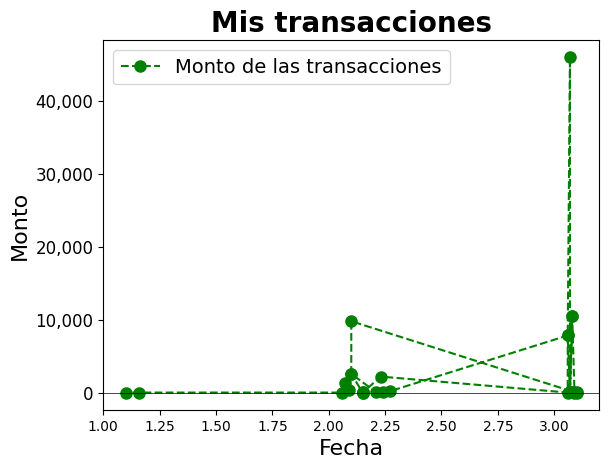

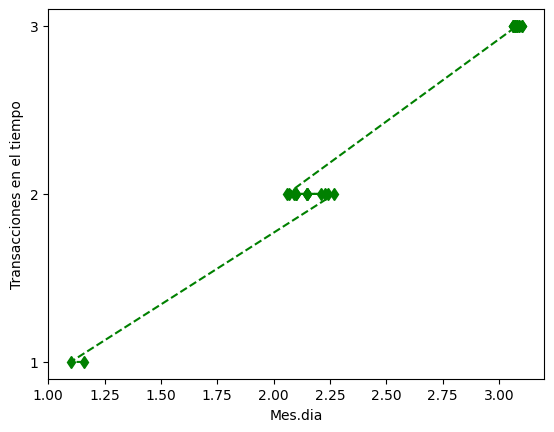

30 transacciones realizadas en total
--------------------------------------------
++Mes 1
1.1
1.16
2 transacciones realizadas en el mes 1

++Mes 2
2.06
2.07
2.09
2.1
2.1
2.1
2.15
2.15
2.15
2.15
2.21
2.23
2.24
2.27
14 transacciones realizadas en el mes 2

++Mes 3
3.06
3.06
3.06
3.07
3.07
3.07
3.07
3.07
3.08
3.08
3.09
3.09
3.1
3.1
14 transacciones realizadas en el mes 3


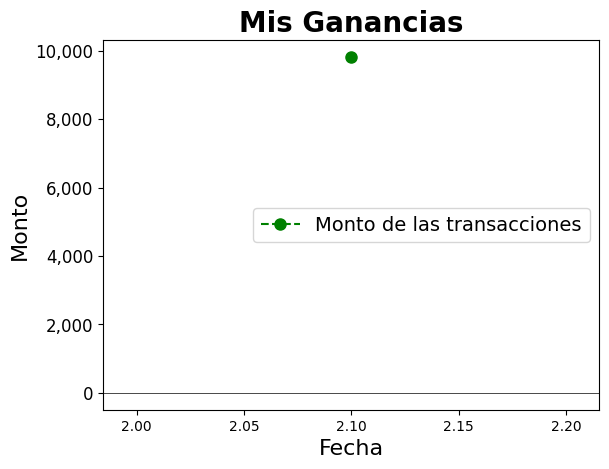

1 transacciones realizadas en total
--------------------------------------------
++Mes 2
2.1
1 transacciones realizadas en el mes 2


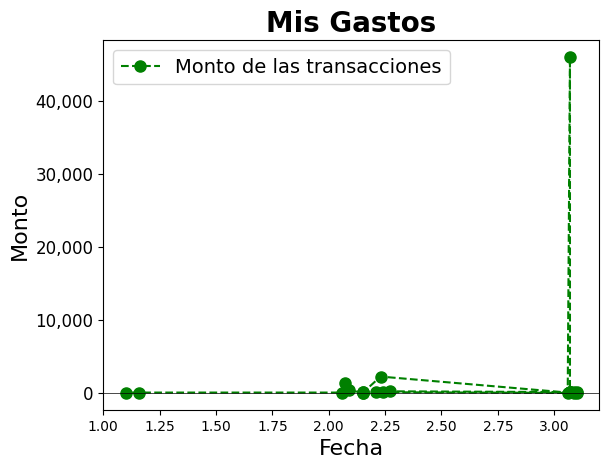

23 transacciones realizadas en total
--------------------------------------------
++Mes 1
1.1
1.16
2 transacciones realizadas en el mes 1

++Mes 2
2.06
2.07
2.09
2.15
2.15
2.15
2.15
2.21
2.23
2.24
2.27
11 transacciones realizadas en el mes 2

++Mes 3
3.06
3.07
3.07
3.07
3.07
3.07
3.09
3.09
3.1
3.1
10 transacciones realizadas en el mes 3


In [99]:
#(0) Matplotlib

def print_details(amount, dates):
    print("{0} transacciones realizadas en total".format(len(amount)))
    print("--------------------------------------------")
    month = int(sorted(dates)[0])+1 
    month_trans = 0
    print("++Mes {0}".format(month-1))
    for index, date in enumerate(sorted(dates)):
        month_trans += 1
        if date > month:
            print("{0} transacciones realizadas en el mes {1}".format(month_trans-1, month-1))
            month += 1
            month_trans = 1
            print("\n++Mes {0}".format(month-1))
        print(date)
    print("{0} transacciones realizadas en el mes {1}".format(month_trans, month-1)) #para imprimir el último mes

def plot_details(amount, dates, titulo):
    # Convertir los valores de la lista "amount" a números (floats)
    float_amount = [a for a in amount]

    # Crear el gráfico
    fig, ax = plt.subplots()
    ax.plot(dates, float_amount, color='green', linestyle='--', marker='o', markersize=8)

    # Configurar el eje y
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_tick_params(labelsize=12)

    # Añadir títulos y etiquetas
    ax.set_title(titulo, fontsize=20, fontweight='bold')
    ax.set_xlabel('Fecha', fontsize=16)
    ax.set_ylabel('Monto', fontsize=16)

    # Añadir una línea horizontal en el valor cero para destacar el punto de equilibrio
    ax.axhline(y=0, color='black', linewidth=0.5)

    # Añadir una leyenda
    ax.legend(['Monto de las transacciones'], fontsize=14)
    # plt.xticks(rotation=90)

    # Mostrar el gráfico
    plt.show()


#(1) Aquí preparo los datos
exchange_rate = usd_to_dop(1)
amount = []
for transaction in df["Efecto"]:
    if "DOP" not in transaction:
        trans = float(transaction.replace('$', '').replace('+', '').replace(' ', '').replace(',', '').replace("*","").replace("-","")) * exchange_rate 
    else:
        trans = float(transaction.replace('$', '').replace('+', '').replace(' ', '').replace(',', '').replace("*","").replace("-","").replace("DOP",""))
    amount.append(trans)
print(amount)
dates = []
for date in df["Fecha"]:
    dates.append(float("{0}.{1}".format(date[3:5], date[:2])))
print(dates)

#(1) Aquí hago los plot (faltaría condicionar optimizar el plot para que sea más acertada la visualización)

#(2) Plot general
##########
#(3) Gráfica 1
plot_details(amount, dates, 'Mis transacciones')

#(3) Gráfica 2
# crea una lista de tuplas que contenga la fecha y la transacción
data = list(zip(dates, amount))

# ordena la lista por el valor de la transacción
sorted_data = sorted(data, key=lambda x: str(x)[1])

# separa la lista en dos listas distintas de fechas y transacciones
sorted_dates = [x[0] for x in sorted_data]
sorted_amount = [str(x)[1] for x in sorted_data]

# crea el plot con las transacciones ordenadas
plot1 = plt.subplot()
plot1.plot(sorted_dates, sorted_amount, 'g--d')
# plot1.invert_yaxis()
plt.ylabel('Transacciones en el tiempo')
plt.xlabel('Mes.dia')
plt.show()

#(3) detalles 
print_details(amount, dates)

###########

#(2) Plot de ganancias en el tiempo
earns = []
earn_dates = []
for index, transaction in enumerate(df["Efecto"]):
    if "+" in transaction and not "*+" in transaction:
        if "DOP" not in transaction:
            trans = float(transaction.replace('$', '').replace('+', '').replace(' ', '').replace(',', '').replace("*","")) * exchange_rate 
        else:
            trans = float(transaction.replace('$', '').replace('+', '').replace(' ', '').replace(',', '').replace("*","").replace("DOP",""))
       
        earns.append(trans)
        earn_dates.append(dates[index])

plot_details(earns, earn_dates, 'Mis Ganancias')
print_details(earns, earn_dates)


###########

#(2) Plot de perdidas en el tiempo
losses = []
loss_dates = []
for index, transaction in enumerate(df["Efecto"]):
    if "-" in transaction and not "*-" in transaction:
        if "DOP" not in transaction:
            trans = float(transaction.replace('$', '').replace('-', '').replace(' ', '').replace(',', '').replace("*","")) * exchange_rate 
        else:
            trans = float(transaction.replace('$', '').replace('-', '').replace(' ', '').replace(',', '').replace("*","").replace("DOP",""))
       
        losses.append(trans)
        loss_dates.append(dates[index])
plot_details(losses, loss_dates, 'Mis Gastos')
print_details(losses, loss_dates)


1        - $60.00DOP
2        - $84.27DOP
3       - $114.69DOP
5       - $219.00DOP
6       - $145.00DOP
7       - $100.00DOP
9        9818.993137
10         - 0.23DOP
11       - 150.00DOP
12         - 0.15DOP
13       - 100.00DOP
15        - 69.00DOP
16    - 46,000.00DOP
18        - 50.00DOP
19     - 2,238.65DOP
20         - 0.15DOP
21       - 100.00DOP
22         - 0.09DOP
23        - 60.00DOP
25       - 337.00DOP
26     - 1,369.00DOP
27        - 50.00DOP
28        - 50.00DOP
29        - 50.00DOP
Name: Efecto, dtype: object
Fecha
01      100.00
02     4797.69
03    46628.18
Name: Cantidad, dtype: float64
{'01': 100.0, '02': 4797.6900000000005, '03': 46628.18}


C:\Users\Saùl Castillo\AppData\Local\Temp\ipykernel_30336\3996324542.py:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Cantidad'] = df['Cantidad'].str.replace('$', '').str.replace(',', '').str.replace('-', '').str.replace('+', '').str.replace(' ', '').astype(float)


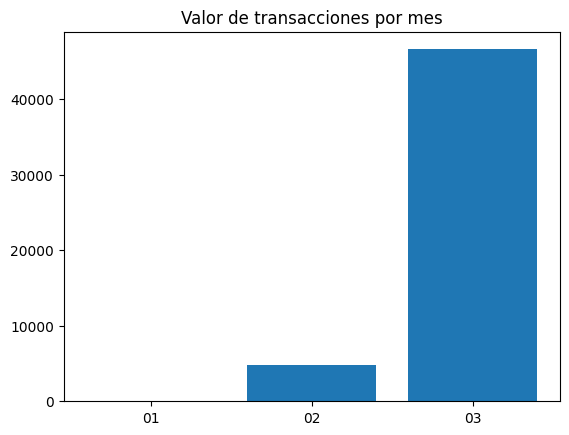

In [105]:
import matplotlib.pyplot as plt
import pandas as pd

# Leer el archivo CSV
df = pd.read_csv('todas_mis_transacciones.csv')

# Seleccionar solo las filas que no contengan un "*"
df = df.loc[~df['Efecto'].str.contains('\*')]
# print(df['Efecto'])

#Convertir los valores en dolares a pesos, para esto compruebbo que no tengan "DOP" ni ninguna otra etiqueta de divisa
exchange_rate = usd_to_dop(1)
df.loc[~df['Efecto'].str.contains('DOP'), 'Efecto'] = df.loc[~df['Efecto'].str.contains('DOP'), 'Efecto'].apply(lambda x: float(x.replace('$', '').replace('+', '').replace(' ', '').replace(',', '').replace("*","").replace("-","")) * exchange_rate)
print(df['Efecto'])

# Convertir la columna 'Cantidad' a un tipo de datos numérico
df['Cantidad'] = df['Cantidad'].str.replace('$', '').str.replace(',', '').str.replace('-', '').str.replace('+', '').str.replace(' ', '').astype(float)

# Agrupar los datos por mes y sumar la cantidad
gastos_por_mes = df.groupby(df['Fecha'].str.split('/').str[1])['Cantidad'].sum()
print(gastos_por_mes)

# Convertir los datos en un diccionario
diccionario_gastos = gastos_por_mes.to_dict()
data = diccionario_gastos

# Imprimir el diccionario
print(diccionario_gastos)

# Convertir los datos en un DataFrame de pandas
df = pd.DataFrame.from_dict(data, orient='index', columns=['Número de transacciones'])

# Gráfico de barras
fig, ax = plt.subplots()
ax.bar(x = df.index, height = df['Número de transacciones'])
# plt.xticks(rotation=90)

# Título
ax.set_title('Valor de transacciones por mes')

# Mostrar el gráfico
plt.show()

['10/02']
DatetimeIndex(['1900-02-10'], dtype='datetime64[ns]', freq=None)
{'Ganancias': {Timestamp('1900-02-28 00:00:00', freq='M'): 9818.993137200001}}
DatetimeIndex(['1900-02-10'], dtype='datetime64[ns]', freq=None)


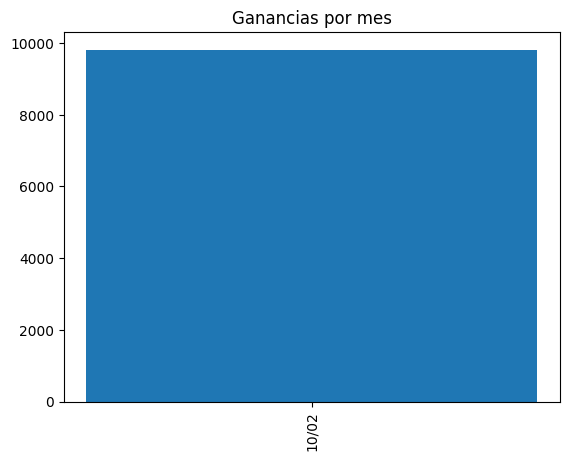

In [76]:
import matplotlib.pyplot as plt
import pandas as pd

# Obtener las ganancias y las fechas de las transacciones
df = pd.read_csv('todas_mis_transacciones.csv')
amount = df['Efecto']
earns = []
earn_dates = []
exchange_rate = usd_to_dop(1)
for index, trans in enumerate(amount):
    if "+" in trans and trans[0] != "*": #* significa que es una transferencia de una cuenta a otra
        if "DOP" in trans:
            earn_dop = float(trans.replace('$', '').replace('+', '').replace(' ', '').replace('DOP','').replace(',', ''))
        else:
            earn_dop = float(trans.replace('$', '').replace('+', '').replace(' ', '').replace(',', '')) * exchange_rate
        
        earns.append(spent_dop)
        earn_dates.append(df["Fecha"][index][:5])

# Convertir las fechas en un formato de fecha de pandas
print(earn_dates)
earn_dates = pd.to_datetime(earn_dates, format='%d/%m')
print(earn_dates)

# Crear un DataFrame de pandas con las ganancias y las fechas
df = pd.DataFrame({'Ganancias': earns}, index=earn_dates)

# Agrupar los datos por mes y sumar las ganancias
gastos_por_mes = df.resample('M').sum()

# Convertir los datos en un diccionario
diccionario_gastos = gastos_por_mes.to_dict()

# Imprimir el diccionario
print(diccionario_gastos)

# Convertir los datos en un DataFrame de pandas
# df = pd.DataFrame.from_dict(diccionario_gastos, orient='index', columns=['Ganancias'])

# Convertir el índice a un objeto DatetimeIndex
df.index = pd.to_datetime(df.index)
print(df.index)

# Gráfico de barras
fig, ax = plt.subplots()
ax.bar(x = df.index.strftime('%d/%m'), height = df['Ganancias'])
ax.invert_xaxis()
plt.xticks(rotation=90)

# Título
ax.set_title('Ganancias por mes')

# Mostrar el gráfico
plt.show()

              Gastos
1900-01-31    100.00
1900-02-28   4618.89
1900-03-31  46628.34
{'Gastos': {Timestamp('1900-01-31 00:00:00', freq='M'): 100.0, Timestamp('1900-02-28 00:00:00', freq='M'): 4618.889999999999, Timestamp('1900-03-31 00:00:00', freq='M'): 46628.34}}


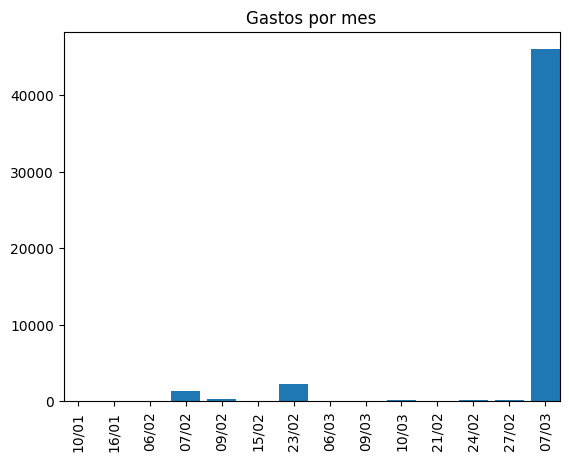

In [73]:
import matplotlib.pyplot as plt
import pandas as pd

# Obtener las ganancias y las fechas de las transacciones
df = pd.read_csv('todas_mis_transacciones.csv')
amount = df['Efecto']
spents = []
spent_dates = []
exchange_rate = usd_to_dop(1)
for index, trans in enumerate(amount):
    if "-" in trans and trans[0] != "*": #* significa que es una transferencia de una cuenta a otra
        if "DOP" in trans:
            spent_dop = float(trans.replace('$', '').replace('-', '').replace(' ', '').replace('DOP','').replace(',', ''))
        else:
            spent_dop = float(trans.replace('$', '').replace('-', '').replace(' ', '').replace(',', '')) * exchange_rate

        spents.append(spent_dop)
        spent_dates.append(df["Fecha"][index][:5])

# Convertir las fechas en un formato de fecha de pandas
spent_dates = pd.to_datetime(spent_dates, format='%d/%m')
# print(spent_dates)

# Crear un DataFrame de pandas con las ganancias y las fechas
df = pd.DataFrame({'Gastos': spents}, index=spent_dates)

# Agrupar los datos por mes y sumar las ganancias
gastos_por_mes = df.resample('M').sum()
print(gastos_por_mes)

# Convertir los datos en un diccionario
diccionario_gastos = gastos_por_mes.to_dict()

# Imprimir el diccionario
print(diccionario_gastos)

# Convertir los datos en un DataFrame de pandas
# df = pd.DataFrame.from_dict(diccionario_gastos, orient='index', columns=['Gastos'])

# Convertir el índice a un objeto DatetimeIndex
df.index = pd.to_datetime(df.index)
# print(df.index)

# Gráfico de barras
fig, ax = plt.subplots()
ax.bar(x = df.index.strftime('%d/%m'), height = df['Gastos'])

plt.autoscale(enable=True, axis = 'x',tight=True)
# ax.set_xlim([0, 10])
# ax.set_ylim([0, 40000])
ax.invert_xaxis()
plt.xticks(rotation=90)

# Título
ax.set_title('Gastos por mes')

# Mostrar el gráfico
plt.show()

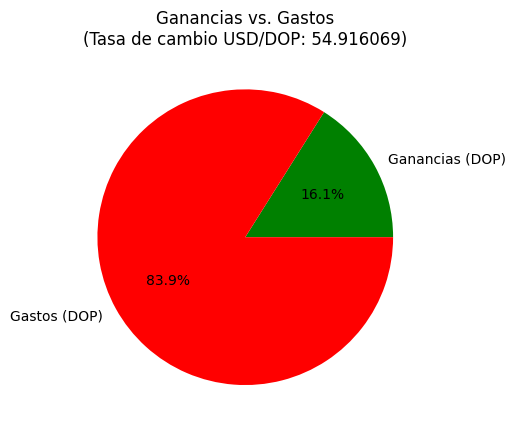

Total de ganancias en USD: 178.8
Total de pérdidas en USD: 0
Total de ganancias en DOP: 0
Total de pérdidas en DOP: 51347.229999999996
Total de ganancias en DOP (convertido desde USD): 9818.993137
Total de pérdidas en DOP (convertido desde USD): 0


In [71]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup

# Obtener las ganancias y las fechas de las transacciones
df = pd.read_csv('todas_mis_transacciones.csv')
amount = df['Efecto']
earnings_usd = []
losses_usd = []
earnings_dop = []
losses_dop = []
for trans in amount:
    if "+" in trans and trans[0] != "*": #* significa que es una transferencia de una cuenta a otra
        if "DOP" in trans:
            earnings_dop.append(float(trans.replace('$', '').replace('-', '').replace(' ', '').replace('DOP','').replace(',', '')))
        else:
            earnings_usd.append(float(trans.replace('$', '').replace('-', '').replace(' ', '').replace(',', '')))
    elif "-" in trans and trans[0] != "*": #* significa que es una transferencia de una cuenta a otra
        if "DOP" in trans:
            losses_dop.append(float(trans.replace('$', '').replace('-', '').replace(' ', '').replace('DOP','').replace(',', '')))
        else:
            losses_usd.append(float(trans.replace('$', '').replace('-', '').replace(' ', '').replace(',', '')))

# Calcular el total de ganancias y pérdidas en dólares y pesos dominicanos (DOP)
total_earnings_usd = sum(earnings_usd)
total_losses_usd = sum(losses_usd)
total_earnings_dop = sum(earnings_dop)
total_losses_dop = sum(losses_dop)

# Convertir los valores de dólares a pesos dominicanos (DOP)
exchange_rate = usd_to_dop(1)

if total_earnings_usd != 0:
    total_earnings_usd_to_dop = usd_to_dop(total_earnings_usd)
else:
    total_earnings_usd_to_dop = 0

if total_losses_usd != 0:
    total_losses_usd_to_dop = usd_to_dop(total_losses_usd)
else:
    total_losses_usd_to_dop = 0

#sumar valores ganancias y perdidas en pesos
total_earnings_pesos = total_earnings_dop + total_earnings_usd_to_dop
total_losses_pesos = total_losses_dop + total_losses_usd_to_dop

# Crear una lista de etiquetas para el gráfico de pastel
labels = ['Ganancias (DOP)', 'Gastos (DOP)']

# Crear una lista de valores para el gráfico de pastel
values = [total_earnings_pesos, total_losses_pesos]

# Crear el gráfico de pastel
fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%', colors=['green','red','blue','orange'])

# Título
ax.set_title('Ganancias vs. Gastos\n(Tasa de cambio USD/DOP: {})'.format(exchange_rate))

# Mostrar el gráfico
plt.show()

#imprimir información
print(f'Total de ganancias en USD: {total_earnings_usd}')
print(f'Total de pérdidas en USD: {total_losses_usd}')
print(f'Total de ganancias en DOP: {total_earnings_dop}')
print(f'Total de pérdidas en DOP: {total_losses_dop}')
print(f'Total de ganancias en DOP (convertido desde USD): {total_earnings_usd_to_dop}')
print(f'Total de pérdidas en DOP (convertido desde USD): {total_losses_usd_to_dop}')

In [61]:
import requests

url = "https://api.apilayer.com/exchangerates_data/convert?to=DOP&from=USD&amount=1"

payload = {}
headers= {
  "apikey": "0sUHpvMtNUkjkp3FUU2ZenV3ZjUl8p0I"
}

response = requests.request("GET", url, headers=headers, data = payload)

status_code = response.status_code
data = response.json()
print(response.text)
exchange_rate = data["info"]["rate"]

usd_amount = 1 # Cantidad en dólares estadounidenses
dop_amount = usd_amount * exchange_rate # Cantidad en pesos dominicanos

print(f'{usd_amount} dólares estadounidenses son {dop_amount} pesos dominicanos')

{
    "success": true,
    "query": {
        "from": "USD",
        "to": "DOP",
        "amount": 1
    },
    "info": {
        "timestamp": 1679876343,
        "rate": 54.916069
    },
    "date": "2023-03-27",
    "result": 54.916069
}

1 dólares estadounidenses son 54.916069 pesos dominicanos


In [64]:
import requests
usd_amount = 100
url = "https://api.apilayer.com/exchangerates_data/convert?to=DOP&from=USD&amount={0}".format(usd_amount)

payload = {}
headers= {
"apikey": "0sUHpvMtNUkjkp3FUU2ZenV3ZjUl8p0I"
}

response = requests.request("GET", url, headers=headers, data = payload)

status_code = response.status_code
data = response.json()
print(response.text)
dop_amount = data["result"]

print(dop_amount)

{
    "success": true,
    "query": {
        "from": "USD",
        "to": "DOP",
        "amount": 100
    },
    "info": {
        "timestamp": 1679876583,
        "rate": 54.916069
    },
    "date": "2023-03-27",
    "result": 5491.6069
}

5491.6069


C:\Users\Saùl Castillo\AppData\Local\Temp\ipykernel_30336\1315948829.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  datos['Cantidad'] = datos['Cantidad'].str.replace('$', '').str.replace(',', '').astype(float)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


True


<Axes: xlabel='Fecha', ylabel='Ingresos'>

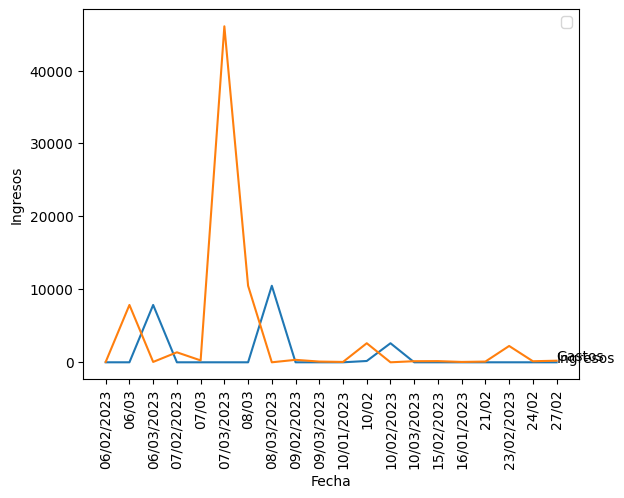

In [18]:
import seaborn as sns
import pandas as pd

# Cargar los datos desde el archivo CSV
datos = pd.read_csv('todas_mis_transacciones.csv')

# Convertir los valores de Cantidad a números
datos['Cantidad'] = datos['Cantidad'].str.replace('$', '').str.replace(',', '').astype(float)
print("-" in datos['Efecto'][0])

# Crear una nueva columna para los ingresos y los gastos
# sns.set(rc={'figure.figsize':(7,7)})
datos['Tipo'] = datos['Efecto'].apply(lambda x: 'Ingreso' if '+' in x else 'Gasto')
datos['Ingresos'] = datos['Cantidad'].where(datos['Tipo'] == 'Ingreso', 0)
datos['Gastos'] = datos['Cantidad'].where(datos['Tipo'] == 'Gasto', 0)
plt.legend()

# Agrupar los datos por fecha y sumar los ingresos y los gastos
datos_agrupados = datos.groupby('Fecha')[['Ingresos', 'Gastos']].sum().reset_index()

plt.text(datos_agrupados['Fecha'].iloc[-1], datos_agrupados['Gastos'].iloc[-1], 'Gastos')
plt.text(datos_agrupados['Fecha'].iloc[-1], datos_agrupados['Ingresos'].iloc[-1], 'Ingresos')
# plt.plot(datos_agrupados['Fecha'][datos_agrupados['Ingresos'].idxmax()], datos_agrupados['Ingresos'].max(), 'ro')
# plt.plot(datos_agrupados['Fecha'][datos_agrupados['Gastos'].idxmax()], datos_agrupados['Gastos'].max(), 'bo')
plt.xticks(rotation=90)

# Crear el gráfico de línea
sns.lineplot(x='Fecha', y='Ingresos', data=datos_agrupados)
sns.lineplot(x='Fecha', y='Gastos', data=datos_agrupados)